# Deploying NLP Classification Model

### Overview

Now that we have a machine learning classification model that can predict whether a business is "closed or open", we can use this model to run predictions on reviews for existing businesses. This will, in theory, only return true positives or false negatives, if reviews are fed in for businesses that we know are still open. However, our goal is to focus on false negatives, which could indicate that the business is at risk of closure. 

1. Run the NLP model on reviews for existing businesses - for this exercise, we will focus on one specific geographic area: the Philadelphia Metro region
1. obtain the list of businesses that have a mean false negative rate of >50% (that is, more than half of the reviews were predicted that the business is not open)
1. Review the trends of these businesses - cluster them geographically using a KNN model, and build a Wordcloud of common themes within the texts to see if negative-skewing trends are noticed (note: the Wordcloud is completed in a separate notebook)

### Next Steps

When running the code below, reviewing the text and business attributes, it is not clear that the reviews directly indicate issues within the operating businesses. Applying our knowledge of the real world, there are likely several issues that result in a business closing, and we would need to explore more sources of data to find root causes of issues within businesses. The beauty of Data Science is that our processes don't guarantee results, and learning from this, we can continue to build upon this baseline to deliver a more robust recommendation system.

In [10]:
import pandas as pd
import numpy as np
import json
import sqlite3
import pickle
from scipy.sparse import hstack, csr_matrix

#packages for preprocessing class uploaded
from sklearn.base import BaseEstimator, TransformerMixin
import nltk 
import re
from nltk import WordNetLemmatizer, pos_tag # lemmatizer using WordNet, nltk's native part of speech tagging
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize # nltk's gold standard word tokenizer
from nltk.tokenize import sent_tokenize # nltk's sentence tokenizer
from nltk.corpus import stopwords, wordnet # imports WordNet and stopwords

#packages to run NLP prediction on texts
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier

from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import folium

import plotly.express as px
import matplotlib.pyplot as plt

from wordcloud import WordCloud

#imported classes for text preprocessing
from TextPreprocessors import TextPreprocessorSTEM, TextPreprocessorLEM

In the interest of time, copying the Stemming class created in base NLP model notebook to ensure everything works. In the future, this class will be saved and called/importing in other notebooks:

In [11]:
with open('data/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as file:
    business_data = [json.loads(line) for line in file]

# Verify the structure of the data and fields names
print(business_data[0]) 

{'business_id': 'Pns2l4eNsfO8kk83dixA6A', 'name': 'Abby Rappoport, LAC, CMQ', 'address': '1616 Chapala St, Ste 2', 'city': 'Santa Barbara', 'state': 'CA', 'postal_code': '93101', 'latitude': 34.4266787, 'longitude': -119.7111968, 'stars': 5.0, 'review_count': 7, 'is_open': 0, 'attributes': {'ByAppointmentOnly': 'True'}, 'categories': 'Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical, Nutritionists', 'hours': None}


In [12]:
metro_states = ['PA', 'NJ', 'DE', 'MD']
filtered_data_business = [d for d in business_data if d.get('state') in metro_states]
business_df = pd.DataFrame(filtered_data_business)
business_df.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
1,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
2,MUTTqe8uqyMdBl186RmNeA,Tuna Bar,205 Race St,Philadelphia,PA,19106,39.953949,-75.143226,4.0,245,1,"{'RestaurantsReservations': 'True', 'Restauran...","Sushi Bars, Restaurants, Japanese","{'Tuesday': '13:30-22:0', 'Wednesday': '13:30-..."
3,ROeacJQwBeh05Rqg7F6TCg,BAP,1224 South St,Philadelphia,PA,19147,39.943223,-75.162568,4.5,205,1,"{'NoiseLevel': 'u'quiet'', 'GoodForMeal': '{'d...","Korean, Restaurants","{'Monday': '11:30-20:30', 'Tuesday': '11:30-20..."
4,PSo_C1Sfa13JHjzVNW6ziQ,Indian Walk Veterinary Center,662 Durham Rd,Newtown,PA,18940,40.273493,-74.987496,5.0,15,1,None,"Pet Services, Pet Groomers, Pets, Veterinarians","{'Monday': '8:0-19:0', 'Tuesday': '8:0-19:0', ..."


In [13]:
business_df['categories'].dropna(axis=0, inplace=True)
business_df.drop('attributes', axis=1, inplace=True)

business_df['categories'] = business_df['categories'].str.split(', ')
business_df_expanded = business_df.explode("categories")
business_df_expanded.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Bubble Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."


In [16]:
# Initialize an empty list to store the retrieved data
reviews = []

# Open the JSON file and load data into the list
#due to memory constraints, capping amount of reviews to 10,000
with open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as file:
    objects_processed = 0
    for line in file:
        dataframe = pd.read_json(line, lines=True)
        if dataframe['business_id'].iloc[0] in set(business_df['business_id']):
            reviews.append(dataframe)
        objects_processed += 1
        if objects_processed >= 10000:
            break
review_df = pd.concat(reviews, ignore_index=True)

review_df.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
3,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31
4,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16


In [17]:
len(set(review_df['business_id']))

1223

In [18]:
review_df['review_count'] = review_df['business_id'].map(
    lambda x: business_df.loc[business_df['business_id'] == x, 'review_count'].values[0])

review_df['business_rating_avg'] = review_df['business_id'].map(
    lambda x: business_df.loc[business_df['business_id'] == x, 'stars'].values[0])


In [19]:
proxy_df = business_df_expanded[business_df_expanded['business_id'].isin(set(review_df['business_id']))]#['is_open'].value_counts()

In [20]:
proxy_df = proxy_df[proxy_df['is_open'] == 1]
proxy_df

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Bubble Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4513,6aoXAXNrL7KrGBVRYBMFWw,Andre Richard Salon,130 Chestnut St,Philadelphia,PA,19106,39.948229,-75.143710,4.5,348,1,Makeup Artists,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-17:0', ..."
4513,6aoXAXNrL7KrGBVRYBMFWw,Andre Richard Salon,130 Chestnut St,Philadelphia,PA,19106,39.948229,-75.143710,4.5,348,1,Blow Dry/Out Services,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-17:0', ..."
4513,6aoXAXNrL7KrGBVRYBMFWw,Andre Richard Salon,130 Chestnut St,Philadelphia,PA,19106,39.948229,-75.143710,4.5,348,1,Shopping,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-17:0', ..."
4513,6aoXAXNrL7KrGBVRYBMFWw,Andre Richard Salon,130 Chestnut St,Philadelphia,PA,19106,39.948229,-75.143710,4.5,348,1,Hair Salons,"{'Monday': '0:0-0:0', 'Tuesday': '10:0-17:0', ..."


### Dataframe preprocessing to predict open status

In [23]:
#run NLP model to predict businesses that aren't open
NLP_model = joblib.load('GB_model_100k_yelp.pkl')

with open('count_vectorizer.pkl', 'rb') as file:
    vectorizer = pickle.load(file) 

other_cols = ['stars', 'business_rating_avg', 'review_count']    
NLP_array = review_df['text']

stemmer = TextPreprocessorSTEM()
stemmed_array = stemmer.fit_transform(NLP_array)

#vectorize the text data
text_vec = vectorizer.transform(stemmed_array)
text_vec = pd.DataFrame.sparse.from_spmatrix(text_vec)
X_values = pd.concat([review_df[other_cols].reset_index(drop=True), text_vec], axis=1)
X_values = csr_matrix(X_values.values)

NLP_preds = NLP_model.predict(X_values)
review_df['prediction_open'] = NLP_preds

In [24]:
review_df.head()


,review_id,user_id,business_id,stars,useful,funny,cool,text,date,review_count,business_rating_avg,prediction_open
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,169,3.0,1
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,144,5.0,1
2,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,181,4.0,0
3,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,273,4.0,1
4,_ZeMknuYdlQcUqng_Im3yg,yfFzsLmaWF2d4Sr0UNbBgg,LHSTtnW3YHCeUkRDGyJOyw,5,2,0,0,Amazingly amazing wings and homemade bleu chee...,2015-08-07 02:29:16,103,3.5,1


In [25]:
#issue with WordCloud visualization in this notebook - saving dataframe to load into separate notebook
review_df.to_csv('review_df_wordcloud.csv', index=False)

In [25]:
#apply the predictions to the business_df_expanded
result_df = review_df.groupby('business_id')['prediction_open'].mean().reset_index()
result_df = result_df[result_df['prediction_open'] <= 0.5]

proxy_df2 = proxy_df[proxy_df['business_id'].isin(set(result_df['business_id']))]
proxy_df2['prediction_open'] = proxy_df2['business_id'].map(
    lambda x: result_df.loc[result_df['business_id'] == x, 'prediction_open'].values[0])

proxy_df2

<ipython-input-25-30e3096f388c>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_df2['prediction_open'] = proxy_df2['business_id'].map(


,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours,prediction_open
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Restaurants,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0.0
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Food,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0.0
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Bubble Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0.0
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Coffee & Tea,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0.0
0,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,Bakeries,"{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ...",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4497,c7OfNRMIqAhtNOMEat3Rbg,Fellini Cafe,3541 W Chester Pike,Newtown Square,PA,19073,39.986747,-75.397289,4.0,156,1,Restaurants,"{'Monday': '11:30-20:30', 'Tuesday': '11:30-20...",0.0
4499,1lp5fBpPwURobaM9pC5-3Q,Royal Chef,1400 Parkway Ave,Ewing,NJ,08628,40.267169,-74.806770,3.5,42,1,Event Planning & Services,"{'Monday': '10:30-22:0', 'Tuesday': '10:30-22:...",0.5
4499,1lp5fBpPwURobaM9pC5-3Q,Royal Chef,1400 Parkway Ave,Ewing,NJ,08628,40.267169,-74.806770,3.5,42,1,Restaurants,"{'Monday': '10:30-22:0', 'Tuesday': '10:30-22:...",0.5
4499,1lp5fBpPwURobaM9pC5-3Q,Royal Chef,1400 Parkway Ave,Ewing,NJ,08628,40.267169,-74.806770,3.5,42,1,Chinese,"{'Monday': '10:30-22:0', 'Tuesday': '10:30-22:...",0.5


In [27]:
coordinates = proxy_df2[['latitude', 'longitude']]
coordinates

,latitude,longitude
0,39.955505,-75.155564
0,39.955505,-75.155564
0,39.955505,-75.155564
0,39.955505,-75.155564
0,39.955505,-75.155564
...,...,...
4497,39.986747,-75.397289
4499,40.267169,-74.806770
4499,40.267169,-74.806770
4499,40.267169,-74.806770


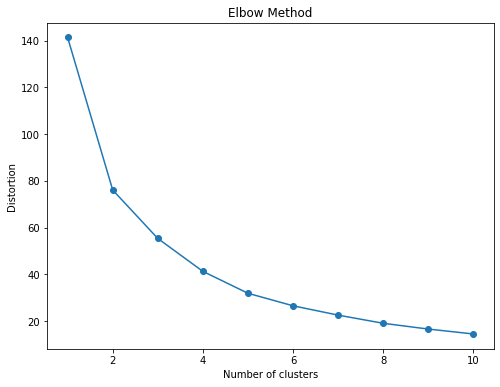

In [28]:
#establish clustering model to determine highest area of businesses at risk
# Find the optimal number of clusters using the elbow method
coordinates = proxy_df2[['latitude', 'longitude']]
distortions = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=0)
    kmeans.fit(coordinates)
    distortions.append(kmeans.inertia_)

# Plot the elbow graph
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

In [29]:
# Choose the optimal number of clusters (e.g., 3 based on the elbow method)
num_clusters = 5

# Fit the KMeans model
kmeans = KMeans(n_clusters=num_clusters, random_state=53)
kmeans.fit(coordinates)

# Add cluster labels to the original dataset
proxy_df2['cluster'] = kmeans.labels_

<ipython-input-29-ecc978298ec6>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  proxy_df2['cluster'] = kmeans.labels_


In [30]:
proxy_df2['cluster'].value_counts()

3    860
0    391
4    306
2    276
1    249
Name: cluster, dtype: int64

Text(0, 0.5, 'Count')

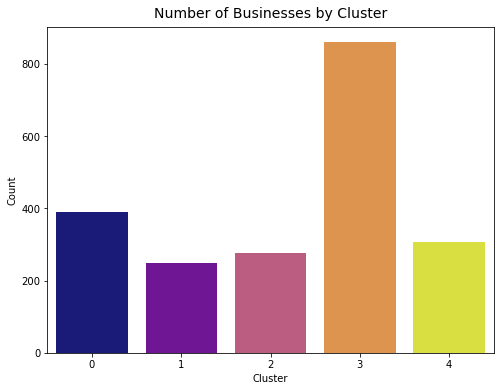

In [34]:
import seaborn as sns
color_codes = ['#0A0B88', '#7601A8', '#CA4D7D', '#F59337', '#F3F927']

plt.figure(figsize=(8, 6))
sns.barplot(x=proxy_df2['cluster'].value_counts().index, y=proxy_df2['cluster'].value_counts().values, palette=color_codes)
plt.title('Number of Businesses by Cluster', fontdict={'fontsize': 14, 'verticalalignment': 'bottom'})
plt.xlabel('Cluster')
plt.ylabel('Count')

In [33]:

# Create the map
min_lat, max_lat = proxy_df2['latitude'].min(), proxy_df2['latitude'].max()
min_lon, max_lon = proxy_df2['longitude'].min(), proxy_df2['longitude'].max()

fig_map = px.scatter_mapbox(proxy_df2, lat="latitude", lon="longitude", color='cluster')
fig_map.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=10,
    mapbox_center=dict(lat=(min_lat + max_lat) / 2, lon=(min_lon + max_lon) / 2),
)

# Show the map
fig_map.show()

# Create a bar plot
plt.figure(figsize=(8, 6))
sns.countplot(x='cluster', data=proxy_df2, palette=fig_map.data[0]['marker']['color'])

# Customize the plot
plt.title('Cluster Counts')
plt.xlabel('Cluster')
plt.ylabel('Count')

# Show the bar plot
plt.show()

ValueError: Could not generate a palette for <map object at 0x0000016418D79CD0>

<Figure size 576x432 with 0 Axes>

In [35]:
#create a map of the data points in question
min_lat, max_lat = proxy_df2['latitude'].min(), proxy_df2['latitude'].max()
min_lon, max_lon = proxy_df2['longitude'].min(), proxy_df2['longitude'].max()

fig = px.scatter_mapbox(proxy_df2, lat="latitude", lon="longitude", color='cluster')

fig.update_layout(
    mapbox_style="open-street-map",
    mapbox_zoom=10,  # Adjust the initial zoom level
    mapbox_center=dict(lat=(min_lat + max_lat) / 2, lon=(min_lon + max_lon) / 2),    
    title_text="Predicted Closed Businesses by Cluster"
)

# Show the map
fig.show()


In [43]:
proxy_df2['categories'].value_counts()

Restaurants     339
Food            143
Nightlife        78
Bars             72
Italian          71
               ... 
Falafel           1
Pet Groomers      1
Electronics       1
Brewpubs          1
Szechuan          1
Name: categories, Length: 264, dtype: int64

In [76]:
#focusing on hospitality - restaurants, food, bars, nightlife categories with those dropped
hospitality_cats = ['Restaurants', 'Food', 'Nightlife', 'Bars']
businesses_array = proxy_df2[proxy_df2['categories'].isin(hospitality_cats)]['business_id'].unique()

proxy_df3 = proxy_df2[(proxy_df2['business_id'].isin(businesses_array)) & (~proxy_df2['categories'].isin(hospitality_cats))]
proxy_df3.shape

(1168, 15)

In [75]:
sum(proxy_df3['categories'].value_counts()[:20].values)

673

### run a KNN model to predict the category

- run KNN model on full businesses dataset to predict the "category" of restaurant 
- data model is trained on will consist of "high-performing" businesses - based off stars for now to create subset df
- prediction model will be ran on businesses that were predicted as "not open", and plotted as before category/after category

In [12]:
proxy_df['categories'].value_counts()

Restaurants       465
Food              221
Nightlife         104
Bars               92
Pizza              87
                 ... 
Laotian             1
Personal Chefs      1
Playgrounds         1
Tui Na              1
Spray Tanning       1
Name: categories, Length: 444, dtype: int64

In [77]:
#creating the subset dataframe
knn_df = business_df_expanded[(business_df_expanded['stars'] >=4) & (business_df_expanded['is_open'] ==1)]

sucessful_bus_array = knn_df[knn_df['categories'].isin(hospitality_cats)]['business_id'].unique()

knn_df2 = knn_df[(knn_df['business_id'].isin(businesses_array)) & (~knn_df['categories'].isin(hospitality_cats))]
knn_df2.shape

(519, 13)

In [78]:
knn_df2['categories'].value_counts()[:10]

Italian                      35
Pizza                        28
Sandwiches                   27
American (New)               20
Breakfast & Brunch           19
American (Traditional)       16
Coffee & Tea                 15
Bakeries                     15
Event Planning & Services    13
Delis                        11
Name: categories, dtype: int64

In [81]:
features = knn_df2[['latitude', 'longitude', 'review_count', 'stars']]
target = knn_df2['categories']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=53)
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)

cat_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, cat_pred)
print(f'Accuracy: {accuracy * 100: .2}%')

Accuracy:  0.96%


### Given the large number of unique values for the "Categories" feature, this model is deemed as irrelevant until a more concise cleaning of the feature is performed.

### Other visualizations to include:

- word cloud of words in predicted close businesses: for some reason, this code could not execute within this Notebook - running in separate notebook within the repository.

In [41]:
plotly_token = 'pk.eyJ1IjoicmVpZG1hamthIiwiYSI6ImNrbXVwdzN1azBsdWQycGxpNHUwZHl0ejgifQ.8oWSNoxy3Gb1w-_aQwVuqw'

In [45]:
min_lat, max_lat = df_expanded['latitude'].min(), df_expanded['latitude'].max()
min_lon, max_lon = df_expanded['longitude'].min(), df_expanded['longitude'].max()

fig = px.scatter_geo(df, lat="latitude", lon="longitude")

# Set the map layout to specify the latitude and longitude bounds
fig.update_geos(
    visible=False,
    lataxis_range=[min_lat, max_lat],
    lonaxis_range=[min_lon, max_lon],
    projection_type="natural earth",
    center=dict(lat=(min_lat + max_lat) / 2, lon=(min_lon + max_lon) / 2)
)

# Show the map
fig.show()